<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BE223C_SPRING_2021/blob/main/VGG_driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys  #to set local import folder
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import csv #read in description files

from google.colab.patches import cv2_imshow


import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
#show model design parameters with torchsummary
import torchsummary
from torchsummary import summary
from torch import FloatTensor
from torch import tensor
from torch.utils.data import DataLoader
from torch import nn


from torchvision import transforms  #get normalization functions

#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files
################################################################################
#
# Load data from google drive
#

drive.mount('/content/gdrive')

#
# SET LOCAL IMPORT DIRECTORY FOR .PY FILES
#
sys.path.append('/content/gdrive/Shareddrives/DBTdata/code/GENERAL_FUNCTIONS/DBT_PY_FILES')


from VGG16 import VGG16


# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image array




### Enable GPU, if present
train_on_gpu = torch.cuda.is_available()
if (train_on_gpu):
    !nvidia-smi -L
    !nvidia-smi 
    dev=torch.device("cuda")
else:
    print('GPU NOT FOUND!!! USING CPU INSTEAD!!!!!')


model_dir = '/content/gdrive/Shareddrives/DBTdata/code/VGG_MODELS'

sys.path.append('/content/gdrive/Shareddrives/DBTdata/code/GENERAL_FUNCTIONS/DBT_PY_FILES')
from TestImageDataset import TestImageDataset
from VGG_Classify import VGG_Classify

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
VGG16(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (vgg16_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)


In [ ]:
!ls '/content/gdrive/Shareddrives/DBTdata/code/GENERAL_FUNCTIONS/DBT_PY_FILES'

create_augmented_data.py  __pycache__	       VGG16.py
CustomImageDataset.py	  TestImageDataset.py  VGG_Classify.py


VGG16(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (vgg16_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3),

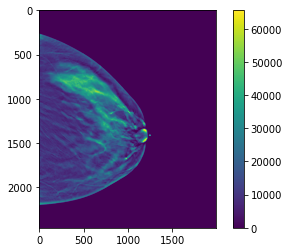

In [ ]:
####################################################
# GENERATE DATA SAMPLE
####################################################

#import VGG16
from VGG16 import VGG16
model_vgg16 = VGG16() #.to(device)
model_vgg16 = model_vgg16.float()
print(model_vgg16)

#GENERATE SAMPLE VOLUME FOR TESTING
sample_dir = '/content/gdrive/Shareddrives/DBTdata/DBT_DATA/IMG_ARRAYS'

sample_file = 'DBT-P03292_DBT-S03262_lcc_Cancer.pickle'

dbt_file = os.path.join(sample_dir,sample_file)
raw_image = pickle.load( open(dbt_file, "rb" ) )
dims = np.shape(raw_image)

plt.figure()
plt.imshow(raw_image[5,:,:])
plt.colorbar()



model_dir = '/content/gdrive/Shareddrives/DBTdata/code/VGG_MODELS'
model_number = 1
if (model_number == 1):
    model_test = 'vgg16_best_accuracy_93_EPOCH_96_0.04582521319389343'
    model_test_index = 'data_index_052521_gpu.pickle'
elif (model_number == 2):
    model_test = 'vgg16_best_accuracy_99_EPOCH_94_0.00040225533302873373'
    model_test_index = 'data_index_052521_gpu.pickle'

final_model = os.path.join(model_dir,model_test) #'vgg16_best_accuracy_81_EPOCH_79') #95_gpu_051821')#'vgg16_best_accuracy_97_gpu_final')

start_point  = -1
patch_x = 244
patch_y = 244

#StudyUID,View,Slice,GTClass,pred_X,pred_Y,pred_width,pred_height,confidence
#DBT-S01541,lmlo,15,Normal,,,,,0.22699964046478271
#DBT-S01541,lmlo,16,Normal,17.633377075195312,1543.7889404296875,196.87840270996094,181.398681640625,0.320894330739975
#DBT-S01541,lmlo,16,Normal,17.633377075195312,1543.7889404296875,196.87840270996094,181.398681640625,0.320894330739975
#DBT-S01541,lmlo,17,Normal,24.001001358032227,1543.2220458984375,191.9607696533203,176.679931640625,0.35758641362190247
#DBT-S01541,lmlo,17,Normal,24.001001358032227,1543.2220458984375,191.9607696533203,176.679931640625,0.35758641362190247
#DBT-S01541,lmlo,18,Normal,,,,,0.25522008538246155
#DBT-S01541,lmlo,19,Normal,,,,,0.21641097962856293

box_info = ['testfile',7,1800,125,2200,80]



prediction = VGG_Classify(raw_image, box_info,final_model)
print('Predicted class number is ', prediction)

In [ ]:
from VGG_Classify import VGG_Classify